In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content
!ln -s "/content/drive/MyDrive/Colab Notebooks/AIBook" /googledrive





Mounted at /content/drive
/content


In [ ]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from PIL import Image
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.applications import VGG16, InceptionResNetV2 , VGG19
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import img_to_array
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import imageio
import glob
from IPython.display import HTML, display
from PIL import ImageFile
from keras.layers import Dense, Conv1D, Flatten, MaxPool1D
from tensorflow.keras.utils import to_categorical

In [ ]:
'''
def convert_to_jpg(input_folder, output_folder):
    # 確保輸出資料夾存在
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 列出輸入資料夾中的所有檔案
    file_list = os.listdir(input_folder)

    for file_name in file_list:
        # 將檔案名稱和副檔名拆開
        name, ext = os.path.splitext(file_name)

        # 確保是圖片檔案
        if ext.lower() in ['.png', '.jpeg', '.jpg']:
            # 讀取圖片
            img_path = os.path.join(input_folder, file_name)
            img = cv2.imread(img_path)

            # 將圖片另存為JPG格式
            output_path = os.path.join(output_folder, name + '.jpg')
            cv2.imwrite(output_path, img)
            print(f"Converted {file_name} to JPG.")

# 輸入資料夾路徑和輸出資料夾路徑
input_folder = '../DATASET/TEST/downdog'
output_folder = 'DATASET/TEST/downdog'

# 執行轉換
convert_to_jpg(input_folder, output_folder)
'''

'\ndef convert_to_jpg(input_folder, output_folder):\n    # 確保輸出資料夾存在\n    if not os.path.exists(output_folder):\n        os.makedirs(output_folder)\n\n    # 列出輸入資料夾中的所有檔案\n    file_list = os.listdir(input_folder)\n\n    for file_name in file_list:\n        # 將檔案名稱和副檔名拆開\n        name, ext = os.path.splitext(file_name)\n\n        # 確保是圖片檔案\n        if ext.lower() in [\'.png\', \'.jpeg\', \'.jpg\']:\n            # 讀取圖片\n            img_path = os.path.join(input_folder, file_name)\n            img = cv2.imread(img_path)\n\n            # 將圖片另存為JPG格式\n            output_path = os.path.join(output_folder, name + \'.jpg\')\n            cv2.imwrite(output_path, img)\n            print(f"Converted {file_name} to JPG.")\n\n# 輸入資料夾路徑和輸出資料夾路徑\ninput_folder = \'../DATASET/TEST/downdog\'\noutput_folder = \'DATASET/TEST/downdog\'\n\n# 執行轉換\nconvert_to_jpg(input_folder, output_folder)\n'

In [ ]:
train_dir = '/googledrive/DATASET/TRAIN' #directory with training images
test_dir = '/googledrive/DATASET/TEST' #directory with testing images

In [ ]:
model_name = "movenet_lightning"

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoint_with_scores = outputs['output_0'].numpy()
    return keypoint_with_scores

In [ ]:



sub_folders = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']  # 子資料夾列表




# 儲存關鍵點座標的字典
movenet_keypoints = {}


# 遍歷子資料夾，處理圖片
for sub_folder in sub_folders:
    folder_path = os.path.join(train_dir, sub_folder)
    image_list = os.listdir(folder_path)

    for image_name in image_list:
        image_path = os.path.join(folder_path, image_name)
        image = load_img(image_path, target_size=(224, 224))


        input_image = tf.expand_dims(image, axis=0)
        input_image = tf.image.resize_with_pad(input_image, input_size, input_size)



        # 使用MoveNet模型進行關鍵點檢測
        reshaped_data = movenet(input_image)
        reshaped_data = reshaped_data.reshape(17, 3)
        keypoints=reshaped_data[:, :2]
        keypoints=np.around(keypoints,2)
        keypoints=keypoints.flatten()
        # 儲存關鍵點座標到字典中，這裡使用子資料夾的名稱作為鍵
        folder_name = os.path.basename(sub_folder)
        image_key = os.path.join(folder_name, image_name)
        movenet_keypoints[image_key] = keypoints





In [ ]:

movenet_keypoints = {k: v for k, v in movenet_keypoints.items() if v is not None}

In [ ]:
# 使用 `next(iter(my_dict))` 取得第一個鍵
first_key = next(iter(movenet_keypoints))



# 使用該鍵來獲取對應的值
first_value = movenet_keypoints['downdog/00000129.jpg']

# 印出第一個鍵值對
print(f"First key: {first_key}")
print(f"First value: {first_value}")


First key: downdog/00000129.jpg
First value: [0.67 0.37 0.66 0.34 0.66 0.34 0.61 0.35 0.6  0.34 0.57 0.4  0.55 0.4
 0.76 0.31 0.72 0.31 0.88 0.17 0.83 0.21 0.18 0.62 0.18 0.62 0.53 0.75
 0.52 0.74 0.84 0.88 0.82 0.86]


In [ ]:
df=pd.DataFrame(movenet_keypoints)
df = df.transpose()
print(df)



                         0     1     2     3     4     5     6     7     8   \
downdog/00000129.jpg   0.67  0.37  0.66  0.34  0.66  0.34  0.61  0.35  0.60   
downdog/00000132.jpg   0.67  0.60  0.67  0.62  0.66  0.62  0.62  0.64  0.61   
downdog/00000133.jpg   0.76  0.47  0.77  0.46  0.77  0.46  0.75  0.43  0.74   
downdog/00000134.jpg   0.62  0.36  0.63  0.34  0.63  0.35  0.58  0.31  0.58   
downdog/00000130.jpg   0.68  0.41  0.69  0.39  0.69  0.39  0.63  0.34  0.63   
...                     ...   ...   ...   ...   ...   ...   ...   ...   ...   
warrior2/00000426.jpg  0.18  0.57  0.16  0.56  0.16  0.56  0.17  0.53  0.17   
warrior2/00000431.jpg  0.32  0.49  0.31  0.50  0.31  0.48  0.32  0.52  0.32   
warrior2/00000427.jpg  0.27  0.47  0.26  0.46  0.26  0.45  0.28  0.45  0.29   
warrior2/00000407.jpg  0.42  0.50  0.40  0.51  0.40  0.48  0.42  0.54  0.42   
warrior2/00000381.jpg  0.31  0.43  0.29  0.44  0.29  0.44  0.32  0.48  0.31   

                         9   ...    24    25    26 

In [ ]:
lists=[]

for i in df.index:
  part=i.split('/')
  lists.append(part[0])

df['target']=lists


target_mapping = {'downdog': 0, 'goddess': 1, 'plank': 2, 'tree':3, 'warrior2':4}
df["target"] = df["target"].map(target_mapping)

df = df.dropna(axis=0)

print(df)

                          0     1     2     3     4     5     6     7     8  \
downdog/00000129.jpg   0.67  0.37  0.66  0.34  0.66  0.34  0.61  0.35  0.60   
downdog/00000132.jpg   0.67  0.60  0.67  0.62  0.66  0.62  0.62  0.64  0.61   
downdog/00000133.jpg   0.76  0.47  0.77  0.46  0.77  0.46  0.75  0.43  0.74   
downdog/00000134.jpg   0.62  0.36  0.63  0.34  0.63  0.35  0.58  0.31  0.58   
downdog/00000130.jpg   0.68  0.41  0.69  0.39  0.69  0.39  0.63  0.34  0.63   
...                     ...   ...   ...   ...   ...   ...   ...   ...   ...   
warrior2/00000426.jpg  0.18  0.57  0.16  0.56  0.16  0.56  0.17  0.53  0.17   
warrior2/00000431.jpg  0.32  0.49  0.31  0.50  0.31  0.48  0.32  0.52  0.32   
warrior2/00000427.jpg  0.27  0.47  0.26  0.46  0.26  0.45  0.28  0.45  0.29   
warrior2/00000407.jpg  0.42  0.50  0.40  0.51  0.40  0.48  0.42  0.54  0.42   
warrior2/00000381.jpg  0.31  0.43  0.29  0.44  0.29  0.44  0.32  0.48  0.31   

                          9  ...    25    26    27 

In [ ]:

shuffled_df = df.sample(frac=1, replace=False, random_state=5)

dataset = shuffled_df.values

print(dataset)
shuffled_df


[[0.16       0.47       0.14       ... 0.89999998 0.31       4.        ]
 [0.15000001 0.57999998 0.13       ... 0.83999997 0.25999999 4.        ]
 [0.44999999 0.91000003 0.43000001 ... 0.72000003 0.07       2.        ]
 ...
 [0.27000001 0.41999999 0.25999999 ... 0.58999997 0.25       4.        ]
 [0.68000001 0.51999998 0.69       ... 0.70999998 0.20999999 0.        ]
 [0.28       0.46000001 0.27000001 ... 0.88       0.34999999 4.        ]]


,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,target
warrior2/00000216.jpg,0.16,0.47,0.14,0.49,0.14,0.46,0.16,0.52,0.15,0.46,...,0.44,0.76,0.62,0.66,0.30,0.91,0.74,0.90,0.31,4
warrior2/00000297.jpg,0.15,0.58,0.13,0.57,0.13,0.56,0.14,0.54,0.14,0.52,...,0.48,0.58,0.70,0.73,0.40,0.84,0.71,0.84,0.26,4
plank/00000391.jpg,0.45,0.91,0.43,0.93,0.43,0.93,0.39,0.89,0.39,0.90,...,0.53,0.61,0.30,0.63,0.30,0.69,0.10,0.72,0.07,2
goddess/00000126.jpg,0.16,0.51,0.14,0.53,0.14,0.49,0.17,0.55,0.17,0.47,...,0.43,0.70,0.79,0.66,0.21,0.93,0.81,0.91,0.21,1
plank/00000361.jpg,0.44,0.30,0.42,0.29,0.45,0.28,0.42,0.31,0.49,0.29,...,0.53,0.65,0.64,0.68,0.63,0.77,0.77,0.78,0.75,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
warrior2/00000429.jpg,0.45,0.42,0.44,0.41,0.45,0.41,0.46,0.39,0.48,0.40,...,0.47,0.85,0.35,0.80,0.61,0.98,0.24,0.97,0.60,4
downdog/00000224.jpg,0.14,0.29,0.11,0.24,0.13,0.29,0.04,0.26,0.10,0.32,...,0.41,0.37,0.28,0.33,0.48,0.52,0.42,0.54,0.43,0
warrior2/00000366.jpg,0.27,0.42,0.26,0.43,0.26,0.42,0.28,0.47,0.27,0.44,...,0.42,0.60,0.61,0.51,0.28,0.71,0.72,0.59,0.25,4
downdog/00000419.jpg,0.68,0.52,0.69,0.53,0.68,0.53,0.67,0.55,0.66,0.55,...,0.38,0.59,0.31,0.59,0.31,0.70,0.22,0.71,0.21,0


In [ ]:
def onehotencoder (df,num):
    L=np.unique(df[num])
    L=list(L)
    label_list=[x for x in range(len(L))]

    data=[]
    for x in df[num]:
        data.append(L.index(x))
    df_onehot=pd.DataFrame(np.zeros((len(df[num]), len(label_list))),columns=label_list)
    for x in range(len(df[num])):
        df_onehot.loc[x,L.index(df[num][x])]=1
    df_onehot.columns=L
    onehot=np.array(df_onehot)
    return onehot

X = dataset[:,0:34].astype(float)
Y = onehotencoder(shuffled_df,'target')
Y

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
'''
X = dataset[:,0:34].astype(float)
Y = dataset[:,34]
Y = to_categorical(Y)
Y
'''

'\nX = dataset[:,0:34].astype(float)\nY = dataset[:,34]\nY = to_categorical(Y)\nY\n'

In [ ]:

model = Sequential()
model.add(Conv1D(16, 2, input_shape=(34,1), activation="relu"))
model.add(Conv1D(32, 2, activation="relu"))
model.add(MaxPool1D())
model.add(Flatten())
model.add(Dense(5, activation="softmax"))
model.summary()
model.compile(loss="MSE", optimizer="adam", metrics=["accuracy"])
model.fit(X, Y, epochs=300, batch_size=128)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 33, 16)            48        
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 32)            1056      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 5)                 2565      
                                                                 
Total params: 3,669
Trainable params: 3,669
Non-trainable params: 0
______________________________________________________

In [ ]:
#測試集的關鍵點資料


movenet_keypoints={}
for sub_folder in sub_folders:
    folder_path = os.path.join(test_dir, sub_folder)
    image_list = os.listdir(folder_path)

    for image_name in image_list:
        image_path = os.path.join(folder_path, image_name)
        image = load_img(image_path, target_size=(224, 224))


        input_image = tf.expand_dims(image, axis=0)
        input_image = tf.image.resize_with_pad(input_image, input_size, input_size)



        # 使用MoveNet模型進行關鍵點檢測
        reshaped_data = movenet(input_image)
        reshaped_data = reshaped_data.reshape(17, 3)
        keypoints=reshaped_data[:, :2]
        keypoints=np.around(keypoints,2)
        keypoints=keypoints.flatten()
        # 儲存關鍵點座標到字典中，這裡使用子資料夾的名稱作為鍵
        folder_name = os.path.basename(sub_folder)
        image_key = os.path.join(folder_name, image_name)
        movenet_keypoints[image_key] = keypoints


In [ ]:
movenet_keypoints = {k: v for k, v in movenet_keypoints.items() if v is not None}

In [ ]:


df=pd.DataFrame(movenet_keypoints)
df = df.transpose()
lists=[]

for i in df.index:
  part=i.split('/')
  lists.append(part[0])

df['target']=lists


target_mapping = {'downdog': 0, 'goddess': 1, 'plank': 2, 'tree':3, 'warrior2':4}
df["target"] = df["target"].map(target_mapping)



df = df.dropna(axis=0)
df.rename(columns={0:'nose_y', 1:'nose_x',2:'left_eye_y',3:'left_eye_x',4:'right_eye_y',5:'right_eye_x',6:'left_ear_y',7:'left_ear_x',8:'right_ear_y',9:'right_ear_x',24:',right_hip_y',25:'right_hip_x',26:'left_knee_y',27:'left_knee_x',28:'right_knee_y',29:'right_knee_x',30:'left_ankle_y',31:'left_ankle_x',32:'right_ankle_y',33:'right_ankle_x'}, inplace=True)
df


,nose_y,nose_x,left_eye_y,left_eye_x,right_eye_y,right_eye_x,left_ear_y,left_ear_x,right_ear_y,right_ear_x,...,right_hip_x,left_knee_y,left_knee_x,right_knee_y,right_knee_x,left_ankle_y,left_ankle_x,right_ankle_y,right_ankle_x,target
downdog/00000005.jpg,0.66,0.26,0.67,0.24,0.67,0.24,0.63,0.21,0.63,0.21,...,0.41,0.57,0.51,0.57,0.50,0.78,0.58,0.77,0.57,0
downdog/00000003.jpg,0.75,0.54,0.76,0.55,0.76,0.55,0.73,0.61,0.73,0.61,...,0.41,0.55,0.30,0.55,0.30,0.80,0.19,0.81,0.19,0
downdog/00000000.jpg,0.73,0.52,0.74,0.51,0.74,0.51,0.71,0.45,0.71,0.45,...,0.66,0.57,0.78,0.58,0.78,0.86,0.88,0.84,0.86,0
downdog/00000006.jpg,0.76,0.39,0.76,0.38,0.76,0.38,0.70,0.36,0.70,0.35,...,0.61,0.55,0.77,0.54,0.77,0.88,0.91,0.83,0.88,0
downdog/00000002.jpg,0.72,0.59,0.73,0.61,0.73,0.62,0.68,0.66,0.68,0.66,...,0.39,0.56,0.23,0.56,0.22,0.82,0.10,0.83,0.09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
warrior2/00000116.jpg,0.05,0.32,0.01,0.34,0.02,0.34,0.01,0.41,0.02,0.40,...,0.47,0.84,0.81,0.73,0.25,0.99,0.94,0.99,0.30,4
warrior2/00000117.jpg,0.17,0.39,0.15,0.42,0.15,0.41,0.17,0.47,0.17,0.46,...,0.41,0.78,0.59,0.55,0.28,0.90,0.77,0.81,0.30,4
warrior2/00000114.jpg,0.23,0.56,0.21,0.56,0.21,0.54,0.22,0.52,0.22,0.48,...,0.39,0.60,0.70,0.74,0.21,0.82,0.74,0.83,0.07,4
warrior2/00000108.jpg,0.05,0.32,0.01,0.34,0.02,0.34,0.01,0.41,0.02,0.40,...,0.47,0.84,0.81,0.73,0.25,0.99,0.94,0.99,0.30,4


In [ ]:
dataset=df.values
X_test = dataset[:,0:34].astype(float)
true_labels = dataset[:,34]
Y_test = to_categorical(true_labels)

In [ ]:
print(model.predict(X_test))
loss, acc = model.evaluate(X_test, Y_test)
print("準確度：{:.2f}".format(acc))
print("los：{:.2f}".format(loss))

15/15 [==============================] - 0s 2ms/step
[[9.9748468e-01 1.8893227e-11 2.5151977e-03 3.0656544e-08 7.8059088e-08]
 [9.9986029e-01 3.5415542e-08 1.3950029e-04 1.7275421e-10 3.3445383e-07]
 [9.9999219e-01 2.0486236e-12 7.7912555e-06 2.3881789e-11 1.9635138e-08]
 ...
 [7.7876898e-08 4.5648064e-02 2.4088079e-06 1.9447270e-06 9.5434755e-01]
 [3.8238575e-08 2.2559408e-04 1.0856718e-06 6.5986249e-05 9.9970728e-01]
 [1.1378060e-06 1.7906589e-02 8.3189580e-06 1.0030968e-04 9.8198366e-01]]
15/15 [==============================] - 0s 3ms/step - loss: 0.0098 - accuracy: 0.9702
準確度：0.97
los：0.01


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,classification_report
predicted_labels = model.predict(X_test)
predicted_labels = np.argmax(predicted_labels, axis=1)
print(true_labels)
print(predicted_labels)

cm = confusion_matrix(true_labels, predicted_labels)



print(classification_report(true_labels, predicted_labels,target_names=sub_folders))

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Confusion Matrix:")
print(cm)

print("Accuracy:", accuracy)
print("加權平均Precision:", precision)
print("加權平均Recall:", recall)
print("加權平均F1-score:", f1)


15/15 [==============================] - 0s 2ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

epochs=300
history = model.fit(X, Y, epochs=epochs, validation_data=(X_test, Y_test), callbacks=[early_stopping])

Epoch 1/300
34/34 [==============================] - 0s 9ms/step - loss: 0.0190 - accuracy: 0.9470 - val_loss: 0.0125 - val_accuracy: 0.9617
Epoch 2/300
34/34 [==============================] - 0s 6ms/step - loss: 0.0192 - accuracy: 0.9452 - val_loss: 0.0103 - val_accuracy: 0.9638
Epoch 3/300
34/34 [==============================] - 0s 6ms/step - loss: 0.0184 - accuracy: 0.9470 - val_loss: 0.0093 - val_accuracy: 0.9723
Epoch 4/300
34/34 [==============================] - 0s 6ms/step - loss: 0.0195 - accuracy: 0.9442 - val_loss: 0.0095 - val_accuracy: 0.9745
Epoch 5/300
34/34 [==============================] - 0s 6ms/step - loss: 0.0197 - accuracy: 0.9442 - val_loss: 0.0097 - val_accuracy: 0.9681
Epoch 6/300
34/34 [==============================] - 0s 7ms/step - loss: 0.0191 - accuracy: 0.9442 - val_loss: 0.0097 - val_accuracy: 0.9702
Epoch 7/300
34/34 [==============================] - 0s 7ms/step - loss: 0.0187 - accuracy: 0.9470 - val_loss: 0.0092 - val_accuracy: 0.9723
Epoch 8/300
3

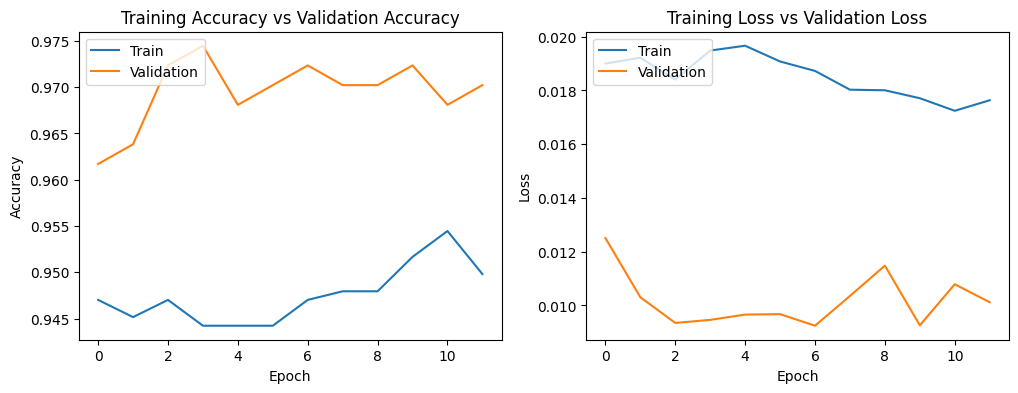

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
train_loss, train_acc = model.evaluate(X, Y)
test_loss, test_acc   = model.evaluate(X_test, Y_test)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

15/15 [==============================] - 0s 3ms/step - loss: 0.0092 - accuracy: 0.9723
final train accuracy = 95.63 , validation accuracy = 97.23


In [ ]:
X_test.shape

(470, 34)

In [ ]:
predicted_labels = model.predict(X_test)
predicted_labels = np.argmax(predicted_labels, axis=1)
print(true_labels)
print(predicted_labels)

cm = confusion_matrix(true_labels, predicted_labels)



print(classification_report(true_labels, predicted_labels,target_names=sub_folders))

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Confusion Matrix:")
print(cm)

print("Accuracy:", accuracy)
print("加權平均Precision:", precision)
print("加權平均Recall:", recall)
print("加權平均F1-score:", f1)

15/15 [==============================] - 0s 2ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3

In [ ]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 改style要在改font之前
# plt.style.use('seaborn')

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

1/1 [==============================] - 0s 23ms/step
[[7.1831941e-08 8.6813394e-05 1.4713664e-05 9.9801815e-01 1.8802722e-03]]


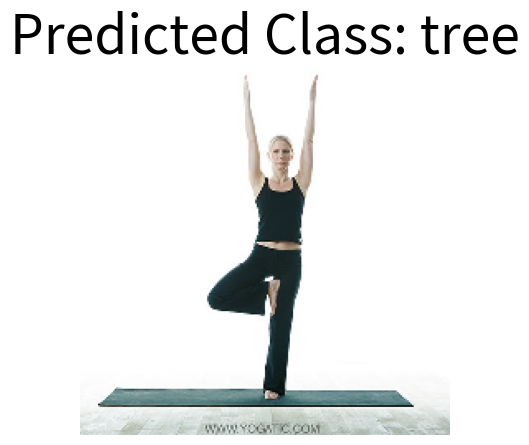

In [328]:
image = load_img('/googledrive/target.jpg', target_size=(224, 224))
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)



# 使用MoveNet模型進行關鍵點檢測
reshaped_data = movenet(input_image)
reshaped_data = reshaped_data.reshape(17, 3)
target_keypoints=reshaped_data[:, :2]
target_keypoints=np.around(target_keypoints,2)
target_keypoints=target_keypoints.flatten()


data_point_array = np.expand_dims(target_keypoints, axis=0)

classes = model.predict(data_point_array)

print(classes)

classes=classes.flatten()

def find_max_index(arr):
    max_val = arr[0]
    max_index = 0

    for i in range(1, len(arr)):
        if arr[i] > max_val:
            max_val = arr[i]
            max_index = i

    return max_index

# 找到最大值的索引

index = find_max_index(classes)






if index == 0:
      pose_name ='downdog'
elif index == 1:
      pose_name ='goddess'
elif index == 2:
      pose_name ='plank'
elif index == 3:
      pose_name ='tree'
else:
      pose_name ='warrior2'


plt.imshow(image)
plt.axis('off')
plt.title('Predicted Class: {}'.format(pose_name))
plt.show()





In [329]:
def draw_prediction_on_image(
     image, keypoints_with_scores, crop_region=None, close_figure=False,
     output_image_height=None):
   """Draws the keypoint predictions on image"""
   height, width, channel = image.shape
   aspect_ratio = float(width) / height
   fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
   # To remove the huge white borders
   fig.tight_layout(pad=0)
   ax.margins(0)
   ax.set_yticklabels([])
   ax.set_xticklabels([])
   plt.axis('off')
   im = ax.imshow(image)
   line_segments = LineCollection([], linewidths=(4), linestyle='solid')
   ax.add_collection(line_segments)
   # Turn off tick labels
   scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)
   (keypoint_locs, keypoint_edges,
    edge_colors) = _keypoints_and_edges_for_display(
        keypoints_with_scores, height, width)
   line_segments.set_segments(keypoint_edges)
   line_segments.set_color(edge_colors)
   if keypoint_edges.shape[0]:
     line_segments.set_segments(keypoint_edges)
     line_segments.set_color(edge_colors)
   if keypoint_locs.shape[0]:
     scat.set_offsets(keypoint_locs)
   if crop_region is not None:
     xmin = max(crop_region['x_min'] * width, 0.0)
     ymin = max(crop_region['y_min'] * height, 0.0)
     rec_width = min(crop_region['x_max'], 0.99) * width - xmin
     rec_height = min(crop_region['y_max'], 0.99) * height - ymin
     rect = patches.Rectangle(
         (xmin,ymin),rec_width,rec_height,
         linewidth=1,edgecolor='b',facecolor='none')
     ax.add_patch(rect)
   fig.canvas.draw()
   image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
   image_from_plot = image_from_plot.reshape(
       fig.canvas.get_width_height()[::-1] + (3,))
   plt.close(fig)
   if output_image_height is not None:
     output_image_width = int(output_image_height / height * width)
     image_from_plot = cv2.resize(
         image_from_plot, dsize=(output_image_width, output_image_height),
          interpolation=cv2.INTER_CUBIC)
   return image_from_plot

In [330]:
def _keypoints_and_edges_for_display(keypoints_with_score,height,width,keypoint_threshold=0.11):
   """Returns high confidence keypoints and edges"""
   keypoints_all = []
   keypoint_edges_all = []
   edge_colors = []
   num_instances,_,_,_ = keypoints_with_score.shape
   for id in range(num_instances):
     kpts_x = keypoints_with_score[0,id,:,1]
     kpts_y = keypoints_with_score[0,id,:,0]
     kpts_scores = keypoints_with_score[0,id,:,2]
     kpts_abs_xy = np.stack(
         [width*np.array(kpts_x),height*np.array(kpts_y)],axis=-1)
     kpts_above_thrs_abs = kpts_abs_xy[kpts_scores > keypoint_threshold,: ]
     keypoints_all.append(kpts_above_thrs_abs)
     for edge_pair,color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
       if (kpts_scores[edge_pair[0]] > keypoint_threshold and
           kpts_scores[edge_pair[1]] > keypoint_threshold):
         x_start = kpts_abs_xy[edge_pair[0],0]
         y_start = kpts_abs_xy[edge_pair[0],1]
         x_end = kpts_abs_xy[edge_pair[1],0]
         y_end = kpts_abs_xy[edge_pair[1],1]
         lien_seg = np.array([[x_start,y_start],[x_end,y_end]])
         keypoint_edges_all.append(lien_seg)
         edge_colors.append(color)
   if keypoints_all:
     keypoints_xy = np.concatenate(keypoints_all,axis=0)
   else:
     keypoints_xy = np.zeros((0,17,2))
   if keypoint_edges_all:
     edges_xy = np.stack(keypoint_edges_all,axis=0)
   else:
     edges_xy = np.zeros((0,2,2))
   return keypoints_xy,edges_xy,edge_colors

In [331]:
# Dictionary to map joints of body part
KEYPOINT_DICT = {
     'nose':0,
     'left_eye':1,
     'right_eye':2,
     'left_ear':3,
     'right_ear':4,
     'left_shoulder':5,
     'right_shoulder':6,
     'left_elbow':7,
     'right_elbow':8,
     'left_wrist':9,
     'right_wrist':10,
     'left_hip':11,
     'right_hip':12,
     'left_knee':13,
     'right_knee':14,
     'left_ankle':15,
     'right_ankle':16
 }

In [332]:
# map bones to matplotlib color name
KEYPOINT_EDGE_INDS_TO_COLOR = {
     (0,1): 'm',
     (0,2): 'c',
     (1,3): 'm',
     (2,4): 'c',
     (0,5): 'm',
     (0,6): 'c',
     (5,7): 'm',
     (7,9): 'm',
     (6,8): 'c',
     (8,10): 'c',
     (5,6): 'y',
     (5,11): 'm',
     (6,12): 'c',
     (11,12): 'y',
     (11,13): 'm',
     (13,15): 'm',
     (12,14): 'c',
     (14,16): 'c'
 }

In [333]:
def face_position(target_keypoint):
  nose_y,nose_x,score=target_keypoint[0,0,0]
  left_eye_y,left_eye_x,score=target_keypoint[0,0,1]
  left_ear_y,left_ear_x,score=target_keypoint[0,0,3]
  right_rar_y,right_ear_x,score=target_keypoint[0,0,4]
  nose_to_left_ear = nose_x - left_ear_x
  nose_to_right_ear = nose_x - right_ear_x


  up=0
  if nose_y-left_eye_y<0:
    up=1
  str=''
  position=0
  if left_ear_x>nose_x and nose_x>right_ear_x:
    if up==0:
      str='使用者面向正面'
      position=1
    else:
      str='使用者倒立面向背面'
      position=2
  elif left_ear_x<nose_x and nose_x<right_ear_x:
    if up ==0:
      str='使用者面向背面'
      position=3
    else:
      str='使用者倒立面向向正面'
      position=4
  elif left_ear_x>nose_x and nose_x<right_ear_x:
    if abs(nose_to_left_ear)-abs(nose_to_right_ear)<0:
      if up==0:
        str='使用者面向背面轉左側'
        position=5
      else:
        str='使用者倒立面向背面轉右側'
        position=6
    elif abs(nose_to_left_ear)-abs(nose_to_right_ear)>0:
      if up==0:
        str='使用者面向正面轉右側'
        position=7
      else:
        str='使用者倒立面向正面轉左側'
        position=8
    else:
      if up==0:
        str='使用者面向右側'
        position=9
      else:
        str='使用者倒立面向左側'
        position=10
  elif left_ear_x<nose_x and nose_x>right_ear_x:
    if abs(nose_to_left_ear)-abs(nose_to_right_ear)>0:
      if up==0:
        str='使用者面向背面轉右側'
        position=11
      else:
        str='使用者倒立面向背面轉左側'
        position=12
    elif abs(nose_to_left_ear)-abs(nose_to_right_ear)<0:
      if up==0:
        str='使用者面向正面轉左側'
        position=13
      else:
        str='使用者倒立面向正面轉右側'
        position=14
    else:
      if up ==0:
        str='使用者面向左側'
        position=15
      else:
        str='使用者倒立面向右側'
        position=16
  return position,str

In [334]:
target_dir =  r'/googledrive/target.jpg'
# Load the input image.
image_path = target_dir
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)

# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

使用者面向正面


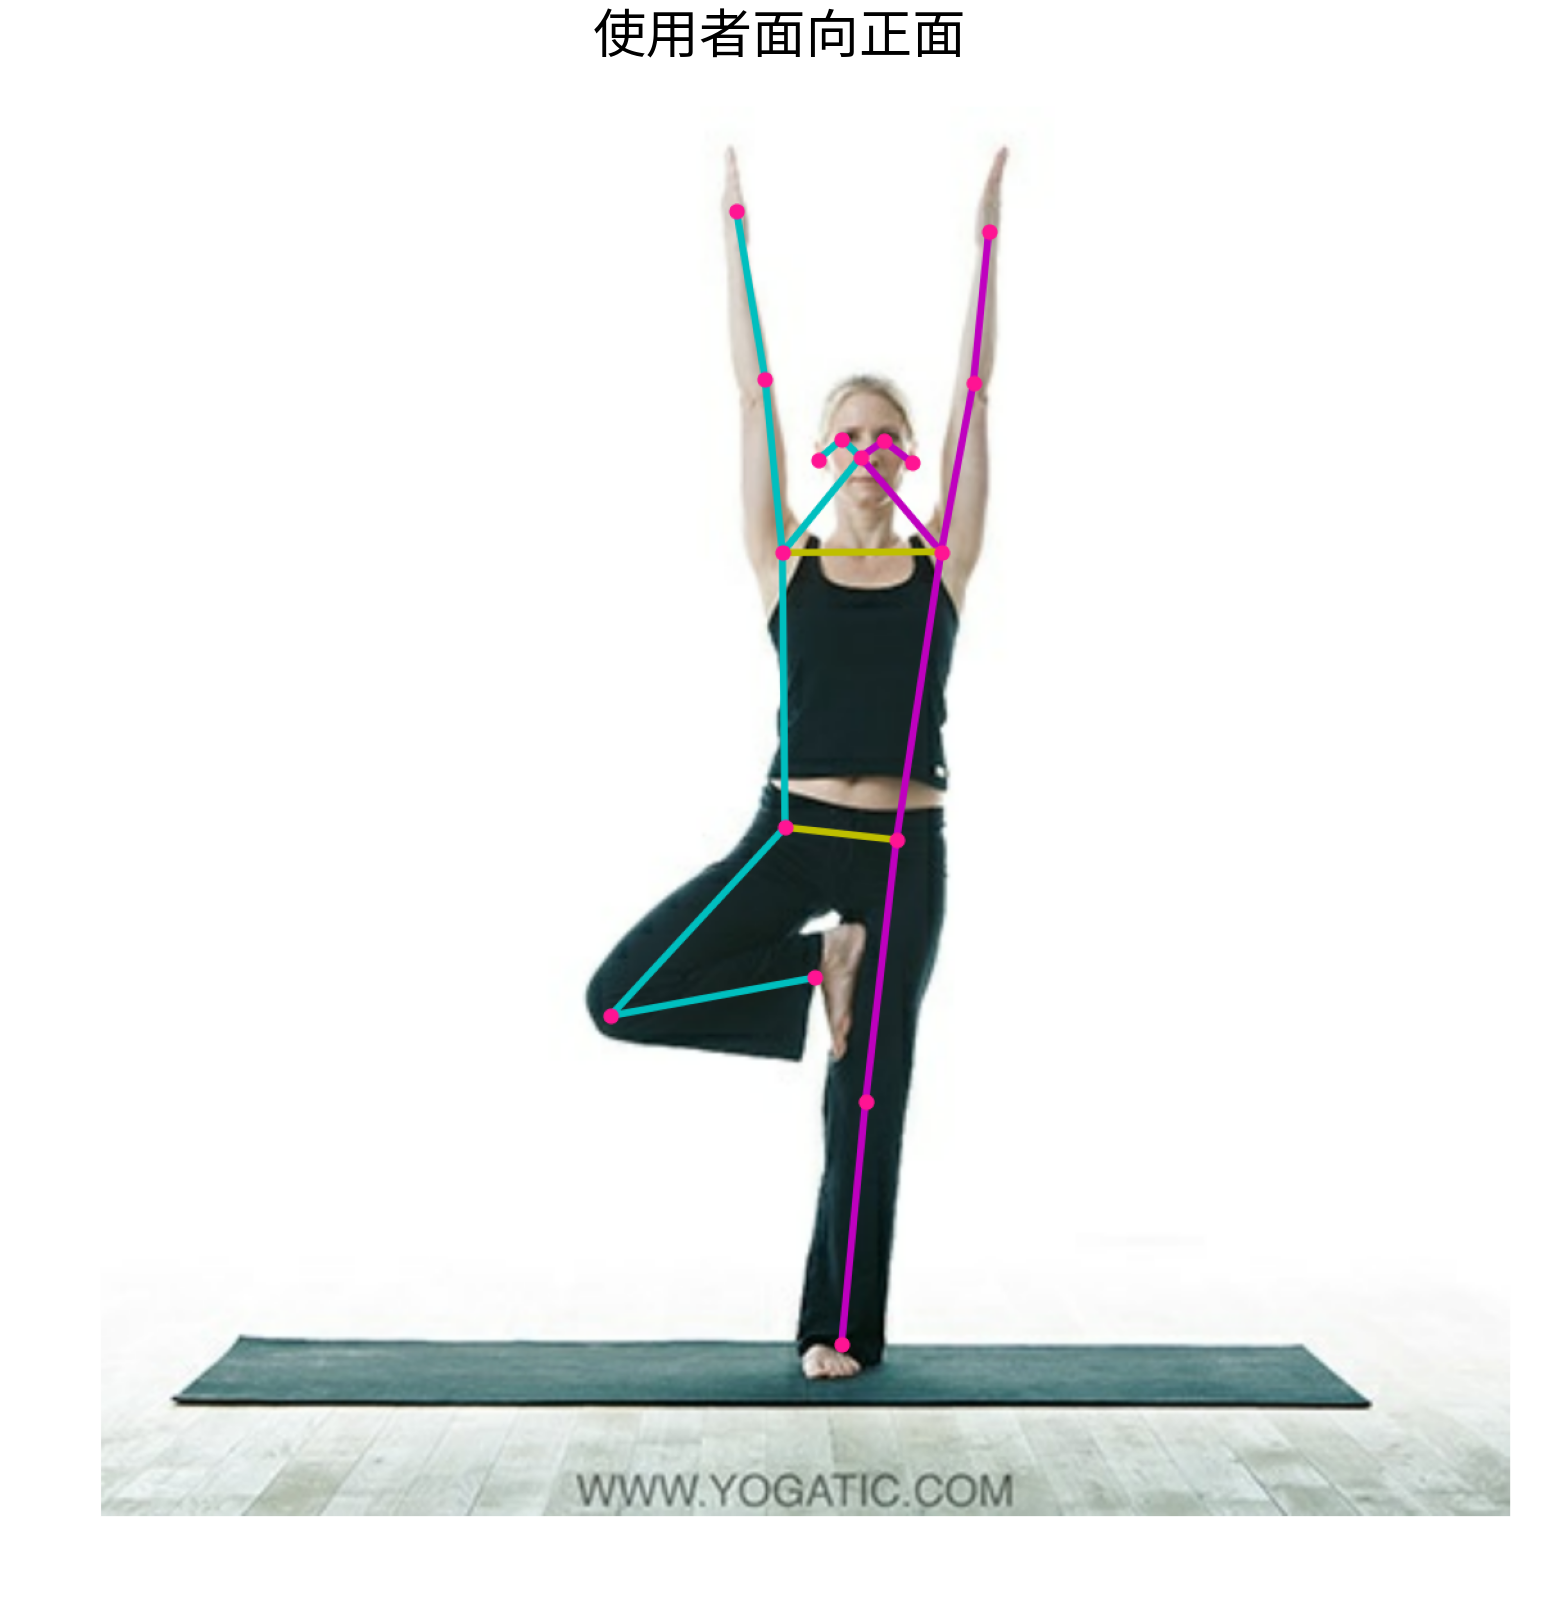

In [335]:

# Run model inference.
keypoint_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoint_with_scores)



p,position=face_position(keypoint_with_scores)
print(position)

plt.figure(figsize=(20, 20))
plt.imshow(output_overlay)
plt.title(position)
_ = plt.axis('off')
target_keypoint=keypoint_with_scores

In [336]:
nose_y,nose_x,score=target_keypoint[0,0,0]
left_ear_y,left_ear_x,score=target_keypoint[0,0,3]
right_rar_y,right_ear_x,score=target_keypoint[0,0,4]
nose_to_left_ear = nose_x - left_ear_x
nose_to_right_ear = nose_x - right_ear_x

left_eye_y,left_eye_x,score=target_keypoint[0,0,1]
print(nose_x)
print(left_ear_x)
print(right_ear_x)
print('y')
print(nose_y)
print(left_eye_y)
print(p)

0.5383055
0.5753658
0.5080215
y
0.24789608
0.23630789
1


標準的tree姿勢為:


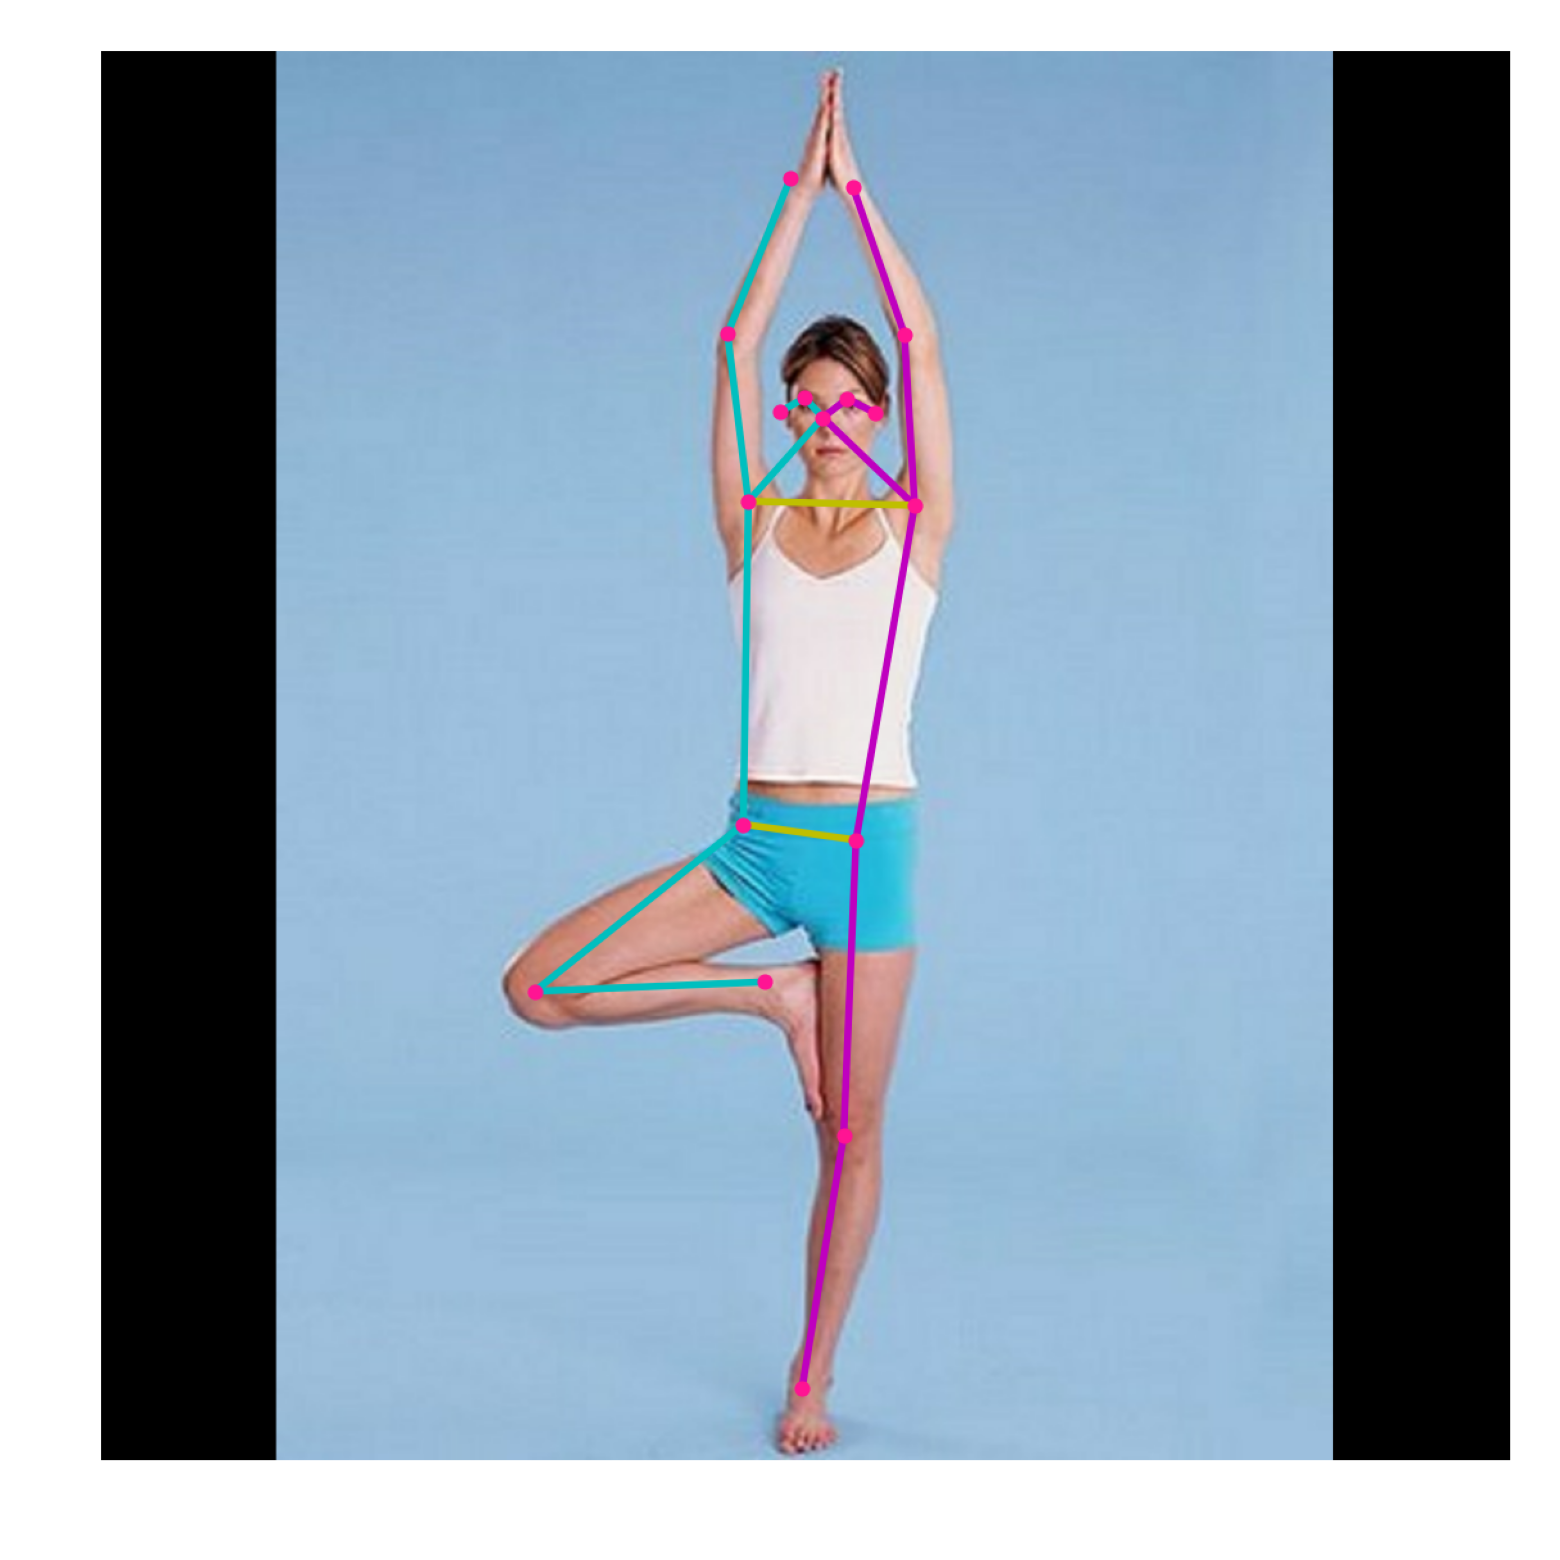

In [337]:
print('標準的{}姿勢為:'.format(pose_name))


'''
  if left_ear_x<nose_x and nose_x<right_ear_x:
    if nose_to_left_ear>0:
      if up==0:
        str='使用者面向正面'
        position=1
      else:
        str='使用者倒立面向背面'
        position=2
    else:
      if up ==0:
        str='使用者面向向背面'
        position=3
      else:
        str='使用者倒立面向向正面'
        position=4
  elif left_ear_x>nose_x and nose_x<right_ear_x:
    if abs(nose_to_left_ear)-abs(nose_to_right_ear)<0:
      if up==0:
        str='使用者面向背面轉左側'
        position=5
      else:
        str='使用者倒立面向背面轉右側'
        position=6
    elif abs(nose_to_left_ear)-abs(nose_to_right_ear)>0:
      if up==0:
        str='使用者面向正面轉右側'
        position=7
      else:
        str='使用者倒立面向正面轉左側'
        position=8
    else:
      if up==0:
        str='使用者面向右側'
        position=9
      else:
        str='使用者倒立面向左側'
        position=10
  elif left_ear_x<nose_x and nose_x>right_ear_x:
    if abs(nose_to_left_ear)-abs(nose_to_right_ear)>0:
      if up==0:
        str='使用者面向背面轉右側'
        position=11
      else:
        str='使用者倒立面向背面轉左側'
        position=12
    elif abs(nose_to_left_ear)-abs(nose_to_right_ear)<0:
      if up==0:
        str='使用者面向正面轉左側'
        position=13
      else:
        str='使用者倒立面向正面轉右側'
        position=14
    else:
      if up ==0:
        str='使用者面向左側'
        position=15
      else:
        str='使用者倒立面向右側'
        position=16
'''

nose_y,nose_x,score=target_keypoint[0,0,0]
left_ear_y,left_ear_x,score=target_keypoint[0,0,3]
right_rar_y,right_ear_x,score=target_keypoint[0,0,4]
left_eye_y,left_eye_x,score=target_keypoint[0,0,1]
nose_to_left_ear = nose_x - left_ear_x
nose_to_right_ear = nose_x - right_ear_x

left_elbow_y,left_elbow_x,score=target_keypoint[0,0,7]
left_shoulder_y,left_shoulder_x,score=target_keypoint[0,0,5]
right_shoulder_y,right_shoulder_x,score=target_keypoint[0,0,6]
left_up=[5,13,15]
left_down=[8,10,12]
right_up=[7,9,11]
right_down=[6,14,16]

left_knee_y,left_knee_x,score=target_keypoint[0,0,13]
right_knee_y,right_knee_x,score=target_keypoint[0,0,14]

if index == 0:
  if nose_x>left_ear_x  :
    example_dir = r'/googledrive/standard/downdog_L.jpg'
  else:
    example_dir = r'/googledrive/standard/downdog_R.jpg'
elif index == 1:
  if left_elbow_y > left_shoulder_y:
    example_dir = r'/googledrive/standard/goddess_close.jpg'
  else:
    example_dir = r'/googledrive/standard/goddess_open.jpg'
elif index == 2:
  if nose_y > left_eye_y and nose_x>left_shoulder_x :
    example_dir = r'/googledrive/standard/plank_UL.jpg'
  elif nose_y > left_eye_y and nose_x>left_shoulder_x :
    example_dir = r'/googledrive/standard/plank_DR.jpg'
  elif nose_y < left_eye_y and nose_x<left_shoulder_x :
    example_dir = r'/googledrive/standard/plank_UR.jpg'
  else:
    example_dir = r'/googledrive/standard/plank_DL.jpg'
elif index == 3:
  if left_knee_x>left_shoulder_x:
    example_dir = r'/googledrive/standard/tree_left_leg.jpg'
  elif right_knee_x < right_shoulder_x:
    example_dir = r'/googledrive/standard/tree_right_leg.jpg'
  else:
    example_dir = r'/googledrive/standard/tree_left_leg.jpg'
else:
  if nose_x>left_ear_x :
    example_dir = r'/googledrive/standard/warrior2_L.jpg'
  else :
    example_dir = r'/googledrive/standard/warrior2_R.jpg'


# Load the input image.
image_path = example_dir
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)
# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoint_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoint_with_scores)

plt.figure(figsize=(20, 20))
plt.imshow(output_overlay)
_ = plt.axis('off')


In [338]:
example_keypoint=keypoint_with_scores

example_keypoint

array([[[[0.2594404 , 0.51151615, 0.7464057 ],
         [0.24615389, 0.52886504, 0.6219531 ],
         [0.24542837, 0.4986353 , 0.52899325],
         [0.25616032, 0.54849344, 0.6936874 ],
         [0.25531402, 0.4813003 , 0.7315869 ],
         [0.3218273 , 0.5766572 , 0.7972434 ],
         [0.31890196, 0.45862526, 0.7019877 ],
         [0.20030598, 0.56939757, 0.75204235],
         [0.20006756, 0.4438412 , 0.85302365],
         [0.09583415, 0.53285044, 0.676332  ],
         [0.08946594, 0.4885015 , 0.6651613 ],
         [0.55937934, 0.5350307 , 0.70725405],
         [0.54822224, 0.4549783 , 0.7714744 ],
         [0.76946807, 0.5262729 , 0.85528386],
         [0.66677487, 0.3069753 , 0.78589433],
         [0.9490092 , 0.49663264, 0.7391046 ],
         [0.6601161 , 0.47002274, 0.7152624 ]]]], dtype=float32)

In [339]:
def calculate_angle(keypoint1, keypoint2):

    y1, x1, score1 = keypoint1
    y2, x2, score2 = keypoint2

    # 計算相對於第一個關鍵點的向量
    vector = np.array([x2 - x1, y2 - y1])

    # 使用 arctan2 計算角度，並將弧度轉換為度
    angle_rad = np.arctan2(vector[1], vector[0])
    angle_deg = np.degrees(angle_rad)

    return angle_deg


In [340]:
print('目標對象在左膝到左腳踝的角度:',calculate_angle(target_keypoint[0,0,13], target_keypoint[0,0,15]))

print('標準姿勢在左膝到左腳踝的角度:',calculate_angle(example_keypoint[0,0,13], example_keypoint[0,0,15]))

print('目標對象與標準姿勢在左膝到左腳踝的角度差異:',calculate_angle(target_keypoint[0,0,13], target_keypoint[0,0,15])-calculate_angle(example_keypoint[0,0,13], example_keypoint[0,0,15]))

目標對象在左膝到左腳踝的角度: 95.66171
標準姿勢在左膝到左腳踝的角度: 99.374344
目標對象與標準姿勢在左膝到左腳踝的角度差異: -3.7126312


In [341]:

def calculate_angle_difference(start_keypoint, end_keypoint, target_keypoint, example_keypoint):

    target_start_keypoint = target_keypoint[0, 0, start_keypoint]
    target_end_keypoint = target_keypoint[0, 0, end_keypoint]

    example_start_keypoint = example_keypoint[0, 0, start_keypoint]
    example_end_keypoint = example_keypoint[0, 0, end_keypoint]


    target_angle = calculate_angle(target_start_keypoint, target_end_keypoint)
    example_angle = calculate_angle(example_start_keypoint, example_end_keypoint)
    angle_difference = target_angle - example_angle

    return angle_difference




KEYPOINT_DICT = {
     'nose':0,
     'left_eye':1,
     'right_eye':2,
     'left_ear':3,
     'right_ear':4,
     'left_shoulder':5,
     'right_shoulder':6,
     'left_elbow':7,
     'right_elbow':8,
     'left_wrist':9,
     'right_wrist':10,
     'left_hip':11,
     'right_hip':12,
     'left_knee':13,
     'right_knee':14,
     'left_ankle':15,
     'right_ankle':16
 }


data = {
    'start_keypoint': [9,7,3,5,11,13],
    'end_keypoint': [7,5,5,11,13,15],
    'angle difference': [0,0,0,0,0,0],
}

df = pd.DataFrame(data, index=['left_wrist to left_elbow','left_elbow to left_shoulder','left_ear to left_shoulder','left_shoulder to left_hip','left_hip to left_knee' ,'left_knee to left_ankle'])



df['angle difference'] = df.apply(lambda row: calculate_angle_difference(row['start_keypoint'], row['end_keypoint'], target_keypoint, example_keypoint), axis=1)
print('left side of body:')
print(df)


data = {
    'start_keypoint': [10,8,4,6,12,14],
    'end_keypoint': [8,6,6,12,14,16],
    'angle difference': [0,0,0,0,0,0],
}

df = pd.DataFrame(data, index=['right_wrist to right_elbow','right_elbow to right_shoulder','right_ear to right_shoulder','right_shoulder to right_hip','right_hip to right_knee' ,'right_knee to right_ankle'])



df['angle difference'] = df.apply(lambda row: calculate_angle_difference(row['start_keypoint'], row['end_keypoint'], target_keypoint, example_keypoint), axis=1)
print('\n')
print('right side of body:')
print(df)





left side of body:
                             start_keypoint  end_keypoint  angle difference
left_wrist to left_elbow                  9             7         25.082672
left_elbow to left_shoulder               7             5         14.227104
left_ear to left_shoulder                 3             5          5.532066
left_shoulder to left_hip                 5            11         -1.106407
left_hip to left_knee                    11            13          4.333939
left_knee to left_ankle                  13            15         -3.712631


right side of body:
                               start_keypoint  end_keypoint  angle difference
right_wrist to right_elbow                 10             8        -31.661705
right_elbow to right_shoulder               8             6          1.405037
right_ear to right_shoulder                 4             6          1.394257
right_shoulder to right_hip                 6            12         -1.459320
right_hip to right_knee              